In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Set random seed to ensure reproducible runs
RSEED = 42

Steps followed for Dimensionality Reduction
- Split the dataset to form train and test datasets
- Feature Normalization
- Apply PCA for dimensionality reduction
- Find optimal dimensionality

In [87]:
# Load dataset
df = pd.read_csv('../../DATASET/features_all.csv')
columnHeads = list(df.columns.values)
featureHeads = list(df.columns.values[1:64])
clsHeads = list(df.columns.values[64:])
X_raw = df.loc[:, columnHeads]
y = df.cls_gender.values
# For binary classification [0, 1], replace class '2' with 0.
y[y == 2] = 0

In [88]:
sm = SMOTE(random_state=42)
print('original dataset %s' %Counter(y))
X_res, y_res = sm.fit_sample(X_raw, y)
print('resampled dataset %s' %Counter(y_res))
y_res = y_res.flatten()

original dataset Counter({1: 5054, 0: 3566})
resampled dataset Counter({0: 5054, 1: 5054})


In [89]:
# split dataset to training (70%) and testing (30%) datasets
train_raw, test_raw, train_labels, test_labels = train_test_split(X_res, y_res, 
                                                          stratify = y_res,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [90]:
# Feature normalization/scaling
sc = StandardScaler()
sc.fit(train_raw)
train = sc.transform(train_raw)
test = sc.transform(test_raw)

In [91]:
pca = PCA(n_components = 50)
pca.fit(train)
print('explained variance ratio (first two components): %s' %str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.12475236 0.083594   0.07490575 0.07091747 0.04838679 0.04464731
 0.03967932 0.03751139 0.0350475  0.03380626 0.03148407 0.02874999
 0.02646404 0.02533723 0.02304026 0.02164508 0.02005598 0.01835523
 0.01669283 0.0164445  0.01532537 0.01484036 0.01365742 0.01355183
 0.01328929 0.01284227 0.01219071 0.01053564 0.0099693  0.00880899
 0.00823071 0.00706387 0.00668115 0.0060616  0.00397124 0.00352226
 0.00288152 0.00208218 0.00174726 0.00166326 0.00156117 0.0011967
 0.0009979  0.00070266 0.00068847 0.00063415 0.00059704 0.00048659
 0.00039698 0.00031921]


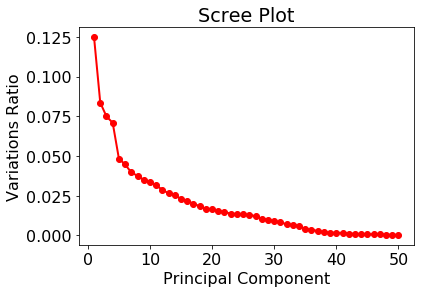

In [92]:
# Plotting scree plot
vars_ratio = pca.explained_variance_ratio_
pcs = range(1, 51)
plt.plot(pcs, vars_ratio, 'ro-', linewidth = 2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variations Ratio')
plt.show()

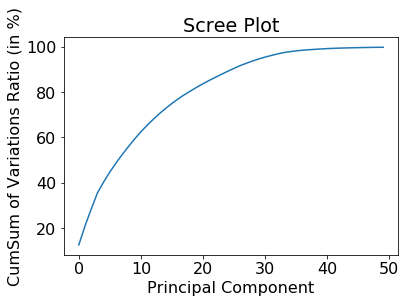

In [93]:
# Plotting cummulative sum of variance across principal components
cumVar=np.cumsum(np.round(vars_ratio, decimals=4)*100)
plt.plot(cumVar)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('CumSum of Variations Ratio (in %)')
plt.show()

In [94]:
print(cumVar[30:40])

[95.46 96.17 96.84 97.45 97.85 98.2  98.49 98.7  98.87 99.04]


In [85]:
optimal_dimen = 35
pca = PCA(n_components = optimal_dimen)
pca.fit(train)
train = pca.transform(train)
test = pca.transform(test)

Hyperparameters Tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
n_estimators.append(10)
n_estimators.append(50)
max_depth = [None] + [int(x) for x in np.linspace(3, 64, 30)]
max_features = ['auto', 'sqrt', 'log2', None] + list(np.arange(0.5, 1, 0.1))
max_leaf_nodes = [None] + list(np.linspace(10, 500, 50).astype(int))
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
bootstrap = [True, False]
# Hyperparameter grid
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'max_leaf_nodes': max_leaf_nodes,
    'min_samples_split': min_samples_split,
    'bootstrap': [True, False]
}

In [44]:
estimator = RandomForestClassifier(class_weight='balanced', random_state = RSEED)
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 5, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# rs = GridSearchCV(estimator, param_grid, cv=5,
#                    scoring='precision')

# Fit 
rs.fit(train, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.7s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 10, 50], 'max_depth': [None, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 45, 47, 49, 51, 53, 55, 57, 59, 61, 64], 'max_features': ['auto', 'sqrt', 'log2', None, 0.5, 0.6, 0.7, 0.7...mples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs',

In [54]:
rs.best_params_

{'bootstrap': False,
 'max_depth': 19,
 'max_features': 'log2',
 'max_leaf_nodes': 300,
 'min_samples_split': 0.6,
 'n_estimators': 10}

In [47]:
best_model = rs.best_estimator_

train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [50]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    #Compare machine learning model to baseline performance. Computes statistics and shows ROC curve.
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(metric.capitalize() + ' Baseline: ' + str(round(baseline[metric], 2)) + ' Test: ' + str(round(results[metric], 2)) + ' Train: ' + str(round(train_results[metric], 2)))
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show()

Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.57 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


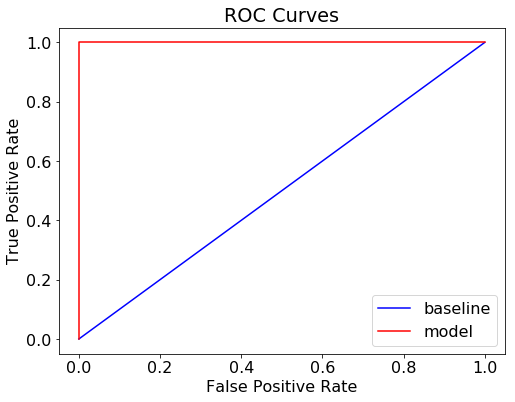

In [51]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [53]:
print(classification_report(test_labels, rf_predictions))
print()

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1107
          1       1.00      1.00      1.00      1479

avg / total       1.00      1.00      1.00      2586


